## 0. Getting setup

As we've done previously, let's make sure we've got all of the modules we'll need for this section.

We'll import the Python scripts (such as `data_setup.py` and `engine.py`) we created in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).

To do so, we'll download [`going_modular`](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular) directory from the `pytorch-deep-learning` repository (if we don't already have it).

We'll also get the [`torchinfo`](https://github.com/TylerYep/torchinfo) package if it's not available.

`torchinfo` will help later on to give us a visual representation of our model.

And since later on we'll be using `torchvision` v0.13 package (available as of July 2022), we'll make sure we've got the latest versions.

In [61]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.4.1
torchvision version: 0.19.1


In [62]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
summary

<function torchinfo.torchinfo.summary(model: 'nn.Module', input_size: 'INPUT_SIZE_TYPE | None' = None, input_data: 'INPUT_DATA_TYPE | None' = None, batch_dim: 'int | None' = None, cache_forward_pass: 'bool | None' = None, col_names: 'Iterable[str] | None' = None, col_width: 'int' = 25, depth: 'int' = 3, device: 'torch.device | str | None' = None, dtypes: 'list[torch.dtype] | None' = None, mode: 'str | None' = None, row_settings: 'Iterable[str] | None' = None, verbose: 'int | None' = None, **kwargs: 'Any') -> 'ModelStatistics'>

> **Note:** If you're using Google Colab and the cell above starts to install various software packages, you may have to restart your runtime after running the above cell. After restarting, you can run the cell again and verify you've got the right versions of `torch` and `torchvision`.

Now we'll continue with the regular imports, setting up device agnostic code and this time we'll also get the [`helper_functions.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py) script from GitHub.

The `helper_functions.py` script contains several functions we created in previous sections:
* `set_seeds()` to set the random seeds (created in [07. PyTorch Experiment Tracking section 0](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#create-a-helper-function-to-set-seeds)).
* `download_data()` to download a data source given a link (created in [07. PyTorch Experiment Tracking section 1](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#1-get-data)).
* `plot_loss_curves()` to inspect our model's training results (created in [04. PyTorch Custom Datasets section 7.8](https://www.learnpytorch.io/04_pytorch_custom_datasets/#78-plot-the-loss-curves-of-model-0))

> **Note:** It may be a better idea for many of the functions in the `helper_functions.py` script to be merged into `going_modular/going_modular/utils.py`, perhaps that's an extension you'd like to try.


In [63]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# # Try to import the going_modular directory, download it from GitHub if it doesn't work
# try:
#     from going_modular.going_modular import data_setup, engine
#     from helper_functions import download_data, set_seeds, plot_loss_curves
# except:
#     # Get the going_modular scripts
#     print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
#     !git clone https://github.com/mrdbourke/pytorch-deep-learning
#     !mv pytorch-deep-learning/going_modular .
#     !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
#     !rm -rf pytorch-deep-learning
#     from going_modular.going_modular import data_setup, engine
#     from helper_functions import download_data, set_seeds, plot_loss_curves

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`.

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [65]:

# raise ZeroDivisionError

## 10. Using a pretrained ViT from `torchvision.models` on the same dataset

We've discussed the benefits of using pretrained models in [06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/).

But since we've now trained our own ViT from scratch and achieved less than optimal results, the benefits of transfer learning (using a pretrained model) really shine.

### 10.1 Why use a pretrained model?

An important note on many modern machine learning research papers is that much of the results are obtained with large datasets and vast compute resources.

And in modern day machine learning, the original fully trained ViT would likely not be considered a "super large" training setup (models are continually getting bigger and bigger).

Reading the ViT paper section 4.2:

> Finally, the ViT-L/16 model pre-trained on the public ImageNet-21k dataset performs well on most datasets too, while taking fewer resources to pre-train: it could be trained using a standard cloud TPUv3 with 8 cores in approximately **30 days**.

As of July 2022, the [price for renting a TPUv3](https://cloud.google.com/tpu/pricing) (Tensor Processing Unit version 3) with 8 cores on Google Cloud is $8 USD per hour.

To rent one for 30 straight days would cost **$5,760 USD**.

This cost (monetary and time) may be viable for some larger research teams or enterprises but for many people it's not.

So having a pretrained model available through resources like [`torchvision.models`](https://pytorch.org/vision/stable/models.html), the [`timm` (Torch Image Models) library](https://github.com/rwightman/pytorch-image-models), the [HuggingFace Hub](https://huggingface.co/models) or even from the authors of the papers themselves (there's a growing trend for machine learning researchers to release the code and pretrained models from their research papers, I'm a big fan of this trend, many of these resources can be found on [Paperswithcode.com](https://paperswithcode.com/)).

If you're focused on leveraging the benefits of a specific model architecture rather than creating your custom architecture, I'd highly recommend using a pretrained model.

### 10.2 Getting a pretrained ViT model and creating a feature extractor

We can get a pretrained ViT model from `torchvision.models`.

We'll go from the top by first making sure we've got the right versions of `torch` and `torchvision`.

> **Note:** The following code requires `torch` v0.12+ and `torchvision` v0.13+ to use the latest `torchvision` model weights API.

In [66]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.4.1
0.19.1


In [67]:
!ls models

__pycache__        modeling.py        modeling_resnet.py
configs.py         modeling_VA.py


### Setup for new file

In [68]:
!pip install ml_collections

zsh:1: command not found: pip


In [69]:
!git clone https://github.com/byM1902/ViT_visualization/
!mv ViT_visualization/models .
!rm -rf ViT_visualization
!ls models

Cloning into 'ViT_visualization'...
remote: Enumerating objects: 98, done.
remote: Total 98 (delta 0), reused 0 (delta 0), pack-reused 98 (from 1)
Receiving objects: 100% (98/98), 16.27 MiB | 1.41 MiB/s, done.
Resolving deltas: 100% (36/36), done.
mv: rename ViT_visualization/models to ./models: Directory not empty
__pycache__        modeling.py        modeling_resnet.py
configs.py         modeling_VA.py


In [70]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from models.modeling import VisionTransformer, CONFIGS
print("imported succesfully")

imported succesfully


### loading new file

In [71]:
'''loading weights'''
!mkdir -p weights
!wget -O weights/ViT-B_16-224.npz /tmp/Ubuntu.iso https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz

zsh:1: command not found: wget


In [72]:
# !rm -rf weights

## Model state dict loading code

In [73]:
# pretrained_vit
def load_model_state_dict(model, relative_path_to_checkpoints="../Pretrained_checkpoints", filename="model_state.pth"):
    """
    Load the state dictionary of a pretrained model from a sibling directory.

    Parameters:
        model: The model object to load the state dictionary into.
        relative_path_to_checkpoints: Relative path from the current directory to the checkpoint directory (default: '../Pretrained_checkpoints').
        filename: The name of the checkpoint file (default: 'model_state.pth').

    Returns:
        None
    """
    # Create the full path relative to the current directory
    file_path = os.path.join(relative_path_to_checkpoints, filename)
    
    # Load the state dictionary
    # Load the state dictionary
    # print(file_path)
    model_state_dict = torch.load(file_path, map_location='cpu', weights_only=True)
    model.load_state_dict(model_state_dict)
    print(f"Model loaded from {file_path}")


In [74]:
# Prepare Model
config = CONFIGS["ViT-B_16"]
# model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model = VisionTransformer(config, num_classes=10, zero_head=False, img_size=224, vis=True)

# model.load_from(np.load("weights/ViT-B_16-224.npz"))

load_model_state_dict(model, relative_path_to_checkpoints="../Pretrained_checkpoints", filename="model_state_dict.pth")

# write herae model weights loading code tk
model.eval()
print('model change model evaluation is successful!')

Model loaded from ../Pretrained_checkpoints/model_state_dict.pth
model change model evaluation is successful!


In [75]:
model

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0-11): 12 x Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=Tru

In [76]:
class_names=['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck']

## Image loading


In [77]:
import os
import numpy as np

def load_data_from_directory(directory_path):
    """Load images, labels, outputs, and image IDs from the specified directory."""

    
    try:
        # Construct the full paths for each file
        ids_path = os.path.join(directory_path, 'ids.npy')
        images_path = os.path.join(directory_path, 'images.npy')
        labels_path = os.path.join(directory_path, 'labels.npy')
        outputs_path = os.path.join(directory_path, 'outputs.npy')

        # Load the numpy arrays
        img_ids = np.load(ids_path)
        images = np.load(images_path)
        labels = np.load(labels_path)
        outputs = np.load(outputs_path)

        return img_ids, images, labels, outputs

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None, None

# Example usage
directory_path = '../saved_images/correct'  # Adjust as needed
img_ids, images, labels, outputs = load_data_from_directory(directory_path)
preds = np.argmax(outputs,-1)


# Example to check the loaded data
if images is not None:
    print(f"Loaded {images.shape[0]} images, {labels.shape[0]} labels, {outputs.shape[0]} outputs, {img_ids.shape[0]} image IDs.")


Loaded 5 images, 5 labels, 5 outputs, 5 image IDs.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2933714..1.908451].


Label: 6
classname: frog


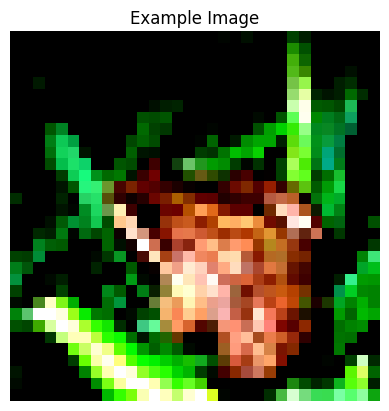

In [78]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image(image_idx, title=None):
    """
    Plot a single image using Matplotlib.

    Args:
        image (numpy.ndarray): The image to plot. It should be in the format (height, width, channels).
        title (str, optional): The title for the plot. Defaults to None.

    Returns:
        None
    """

    # Print label and output
    print(f"Label: {labels[image_idx]}")
    print(f"classname: {class_names[labels[image_idx]]}")
    # print(f"Label class: {class_names[labels[image_idx]]}")
    # print(f"Output: {preds[image_idx]}")

    image = images[image_idx]

    if image.ndim == 3 and image.shape[2] == 3:
        # Color image
        plt.imshow(image)
    elif image.ndim == 2 or (image.ndim == 3 and image.shape[2] == 1):
        # Grayscale image
        if image.ndim == 3:
            image = image.squeeze()  # Remove the channel dimension
        plt.imshow(image, cmap='gray')
    else:
        raise ValueError("Image format not recognized. Expected (H, W) or (H, W, 3) or (H, W, 1).")

    if title:
        plt.title(title)
    
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage
# Assuming `images` is a numpy array of images with shape (k, H, W, C)
# and you want to plot the first image:
image_idx = 3
plot_image(image_idx, title="Example Image")


In [79]:
img_one=images[image_idx:image_idx+1]


In [80]:
type(img_one)

numpy.ndarray

In [81]:
img_one.shape

(1, 32, 32, 3)

In [88]:
# Convert image to PIL image for processing
image_pil = Image.fromarray((img_one.squeeze() * 255).astype(np.uint8))  # Squeeze out the batch dimension

# Define preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),          # Convert image to tensor (C, H, W)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Apply preprocessing to the image
image_tensor = preprocess(image_pil)

# Add batch dimension back (N, C, H, W)
image_tensor = image_tensor.unsqueeze(0)

# print(image_tensor.shape)
# Run the image through the model
with torch.no_grad():  # No need for gradients during testing
    output = model(image_tensor)

# Output will contain logits or predicted classes depending on the model architecture
print(np.argmax(output[0]))


torch.Size([1, 3, 224, 224])
tensor(9)


In [83]:
# import torchvision.transforms as T

# # Define the transform pipeline
# pretrained_vit_transforms = T.Compose([
#     T.Resize((224, 224)),  # Resize the image to 224x224
#     # T.ToTensor(),  # Convert the image to a PyTorch tensor (scales pixel values to [0, 1])
#     T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize with mean and std
# ])

In [84]:
# img_one = np.transpose(img_one, (1, 2, 0))

In [85]:
# img_one = pretrained_vit_transforms(img_one)  # This works with NumPy ar


In [86]:

# with torch.inference_mode():
#     # out = pretrained_vit((pretrained_vit_transforms),torch.tensor(np.transpose(img_one, (0, 3, 1, 2))))
#     # out=model(pretrained_vit_transforms(torch.tensor(np.transpose(img_one, (0, 3, 1, 2)))))
#     out=model(torch.tensor(np.transpose(img_one, (0, 3, 1, 2))))




In [104]:
logits, att_mat = model(image_tensor)

print(len(att_mat))

# att_mat = torch.stack(att_mat).squeeze(1)
# # print(att_mat.shape)
# att_mat = torch.mean(att_mat, dim=1) 
# # print(att_mat.shape)

# residual_att = torch.eye(att_mat.size(1))
# aug_att_mat = att_mat + residual_att
# aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
# # Recursively multiply the weight matrices over 12 layers.
# joint_attentions = torch.zeros(aug_att_mat.size())
# joint_attentions[0] = aug_att_mat[0]
# for n in range(1, aug_att_mat.size(0)):
#     joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
# # The mask matrices over 12 layers correspond with the normal tokens and the class token.
# masks = [] # mask matrices of normal tokens
# masks_cls = [] # mask matrice of class token
# for i in range(len(joint_attentions)):
#   v = joint_attentions[i] # [n_tokens, n_tokens]
#   mask = v[1:, 1:] # 196x196
#   mask = mask/mask.max(axis=0).values
  # mask = mask / mask.max() # [im_w, im_h, 1]
  # masks.append(mask)
  # mask_cls = v[0, 1:] # Attention of token class with patch token
  # mask_cls = mask_cls / mask_cls.max() # [im_w, im_h, 1]
  # masks_cls.append(mask_cls)

12


In [129]:
import torch

def extract_attention_matrix_for_layer(att_mat, layer_idx=0, row_idx=1, head_idx=1):
    """
    Extracts the attention matrix for a particular layer, row (token), and attention head,
    excluding the class token.

    Parameters:
    - att_mat (list of Tensors): List of attention matrices for each layer, where each tensor 
      has shape [1, num_heads, num_tokens, num_tokens] (batch size 1 included).
    - layer_idx (int): The index of the layer to extract from
    - row_idx (int): The index of the token row to extract (1-based if excluding class token)
    - head_idx (int): The index of the attention head to extract

    Returns:
    - extracted_attn (Tensor): Extracted attention matrix for the specified layer, row, and head,
      with the class token removed
    """

    # Step 1: Extract the attention matrix for the specified layer
    attn_layer = att_mat[layer_idx]  # Shape: [1, num_heads, num_tokens, num_tokens]

    # Remove the batch dimension
    attn_layer = attn_layer.squeeze(0)  # Shape: [num_heads, num_tokens, num_tokens]
    print(f"Shape of attention matrix for layer {layer_idx} after squeezing: {attn_layer.shape}")

    # Step 2: Extract the attention matrix for the specific head
    attn_head = attn_layer[head_idx]  # Shape: [num_tokens, num_tokens]
    print(f"Shape after extracting attention for head {head_idx}: {attn_head.shape}")

    # Step 3: Remove the class token (first token)
    attn_no_cls = attn_head[1:, 1:]  # Shape: [n_patches, n_patches]

    # Step 4: Extract attention corresponding to a specific row (token), adjusting for 1-based index
    extracted_attn = attn_no_cls[row_idx - 1, :]  # Shape: [n_patches]


    # Optional normalization for visualization purposes
    extracted_attn = extracted_attn / extracted_attn.max()

    return extracted_attn


In [132]:
attn=extract_attention_matrix_for_layer(att_mat,layer_idx=1,row_idx=2,head_idx=2)

print(attn.shape)

Shape of attention matrix for layer 1 after squeezing: torch.Size([12, 197, 197])
Shape after extracting attention for head 2: torch.Size([197, 197])
torch.Size([196])


## Visualisation and Heatmaps plotting Code

In [168]:
import skimage as ski

def get_threshold(attn_grid,threshold,quantile_value=0.9):
    if threshold == 'mean':
        threshold = attn_grid.mean()
    elif threshold == 'median':
        threshold = attn_grid.median()
    elif threshold == 'decile':
        threshold = torch.quantile(attn_grid, 0.9)
    elif threshold == 'otsu':
        # maximise interclass seperation
        # threshold, _ = cv2.threshold(attn_grid.cpu().numpy(), 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        threshold = ski.filters.threshold_otsu(attn_row.cpu().numpy())
        # attn_grid = torch.tensor(binary_map, dtype=torch.float32)
    elif threshold == 'other':
        # Adjust quantile_value to get the top x% where x = quantile_value * 100
        threshold = torch.quantile(attn_grid, quantile_value)
    else:
        threshold = threshold # You can adjust this threshold as needed
    return threshold

In [169]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_attn_heatmap(attn_row, q_idx, binary=False, threshold = 0.5, figsize = (4, 4),normalize_flag = False, ax=None, overlay = False,quantile_value=0.9):
    # Ensure the tensor is of shape (65,)
    assert attn_row.shape == (196,), "attn_row should have a shape of (65,)"
    
    # Remove the first element (corresponding to the [CLS] token if present)
    attn_grid = attn_row[1:]
    
    # Scaling of all values in attn_grid
    if normalize_flag:
        print("normalized")
        attn_grid = (attn_grid - attn_grid.min()) / (attn_grid.max() - attn_grid.min())
    
    # attn_grid += 
    # Apply binary thresholding if specified
    if binary:
        threshold = get_threshold(attn_grid, threshold,quantile_value)        
        attn_grid = torch.where(attn_grid >= threshold, 1.0, 0.0)
    
    # Reshape to 8x8
    attn_grid = attn_grid.view(15, 13)

    query_coord = ((q_idx-1) // 15, (q_idx-1) % 13)
    
    # Define custom colormap: red, yellow, and blue (only applies if not binary)
    cmap = ListedColormap(['red', 'yellow', 'blue']) if not binary else ListedColormap(['blue', 'red'])
    
    # Define boundaries for the colormap (only applies if not binary)
    bounds = [0, 0.33, 0.66, 1.0] if not binary else [0, threshold, 1.0]
    
    # Define normalization between 0 and 1 using boundaries
    norm = BoundaryNorm(bounds, cmap.N)

    # Plot the heatmap
    # plt.figure(figsize=figsize)
    ax_flag = True

    if ax is None:
        plt.figure(figsize=figsize)
        ax_flag = False
        ax = plt.gca()  # Get the current axis if not provided
        # print("rescaled")

    if overlay and img is not None:
        # Remove the batch dimension
        # img = np.transpose(img, (1, 2, 0))  # Convert to HxWxC format
        attn_grid = attn_grid.cpu().numpy()
        target_size = img.shape[1:3]
        upsampled_attn_grid = cv2.resize(attn_grid, target_size, interpolation=cv2.INTER_NEAREST)
        mask = np.expand_dims(upsampled_attn_grid, axis=-1)  # Shape: (64, 64, 1)
        masked_img = img.squeeze(0) * mask  # Shape: (64, 64, 3)
        target_size = (attn_grid.shape[0], attn_grid.shape[1])

        masked_img = np.clip(masked_img, a_min=0, a_max=1)

        ax.imshow(masked_img)
    else:
        sns.heatmap(attn_grid.cpu().numpy(), annot=False, cmap=cmap, norm=norm, cbar=not(ax_flag), ax=ax, linewidths=0.5, linecolor='black')
        
    # Placing a black dot at the query position
    x = query_coord[1] + 0.5
    y  = query_coord[0] + 0.5
    x *= 4
    y *= 4
    
    ax.scatter(x,y , color='black', s=100, edgecolor='white', zorder=2)
    
    # Set title only if not using an existing axis
    if ax_flag is False:
        plt.title("Attention Heatmap")
        plt.show()
    return threshold

In [172]:
# Example usage
# attn_row = torch.rand(65)  # Example attention row

head_idx=0
print(head_idx)
#frog
q_idx=28
print(q_idx)
layer_idx=5
attn_row = attn
print(attn_row.shape)
# plot_attn_heatmap(attn_row,q_idx, binary=True, threshold='mean')
# plot_attn_heatmap(attn_row,q_idx, binary=True, threshold='median')
# plot_attn_heatmap(attn_row,q_idx, binary=True, threshold='decile')
threshold = plot_attn_heatmap(attn_row,q_idx, binary=True, threshold='otsu', figsize = (4,4), normalize_flag=True,overlay=True,quantile_value=0)
# threshold = plot_attn_heatmap(attn_row,q_idx, binary=True, threshold='otsu', figsize = (4,4), normalize_flag=False)

0
28
torch.Size([196])
normalized


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
raise EOFError

EOFError: 

In [ ]:
# # pretrained_vit
# def load_model_state_dict(model, relative_path_to_checkpoints="../Pretrained_checkpoints", filename="model_state.pth"):
#     """
#     Load the state dictionary of a pretrained model from a sibling directory.

#     Parameters:
#         model: The model object to load the state dictionary into.
#         relative_path_to_checkpoints: Relative path from the current directory to the checkpoint directory (default: '../Pretrained_checkpoints').
#         filename: The name of the checkpoint file (default: 'model_state.pth').

#     Returns:
#         None
#     """
#     # Create the full path relative to the current directory
#     file_path = os.path.join(relative_path_to_checkpoints, filename)
    
#     # Load the state dictionary
#     # Load the state dictionary
#     # print(file_path)
#     model_state_dict = torch.load(file_path, map_location='cpu', weights_only=True)
#     model.load_state_dict(model_state_dict)
#     print(f"Model loaded from {file_path}")


In [ ]:
# # checkpoint_dir = '10 checkpoints'
# # checkpoint_dir='10.8 checkpoints 8 head'

# # checkpoint_dir="Pretrained_checkpoints"
# # filename = 'model_epoch_90.pth'
# # filename = 'model_state_001.pth'
# # 10 checkpoints
# # base_dir="/Users/yajatkapoor/Desktop/IITD SEMESTER-7/ELD431/BTP-Transformer-explainability"
# # base_dir="/path to you base dir"
# # checkpoint_dir=base_dir+'/'+checkpoint_dir
# load_model_state_dict(model, relative_path_to_checkpoints="../Pretrained_checkpoints", filename="model_state_dict.pth")

NameError: name 'model' is not defined

Then we'll setup device-agnostic code.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class_names=['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck']

In [ ]:
num_classes = len(class_names)
num_classes

10

In [ ]:
config = CONFIGS["ViT-B_16"]

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

def get_vit():
  
    pretrained_vit = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=False)
    pretrained_vit.load_from(np.load("weights/ViT-B_16-224.npz"))


    pretrained_vit.train()
    print('model loaded for trianing is successful!')

    # 3. Freeze the base parameters
    for parameter in pretrained_vit.parameters():
      parameter.requires_grad = False

    # 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
    # set_seeds()
    torch.manual_seed(42)

    import torch.nn as nn
    pretrained_vit.head = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
    # pretrained_vit # uncomment for model output
    return pretrained_vit.to(device)

pretrained_vit = get_vit()

model loaded for trianing is successful!


In [ ]:
pretrained_vit

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0-11): 12 x Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=Tru

In [ ]:
pretrained_vit.head

Linear(in_features=768, out_features=10, bias=True)

Pretrained ViT feature extractor model created!

Let's now check it out by printing a `torchinfo.summary()`.

In [ ]:
pretrained_vit

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0-11): 12 x Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=Tru

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                   [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Transformer (transformer)                             [32, 3, 224, 224]    [32, 197, 768]       --                   False
│    └─Embeddings (embeddings)                          [32, 3, 224, 224]    [32, 197, 768]       152,064              False
│    │    └─Conv2d (patch_embeddings)                   [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
│    │    └─Dropout (dropout)                           [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Encoder (encoder)                                [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─ModuleList (layer)                          --                   --                   (85,054,464)         Fal

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-summary-output-pytorch-vit.png" alt="output of pytorch pretrained ViT model summary" width=900 />

Woohoo!

Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

And the total number of parameters, 85,800,963, is the same as our custom made ViT model above.

But the number of trainable parameters for `pretrained_vit` is much, much lower than our custom `vit` at only 2,307 compared to 85,800,963 (in our custom `vit`, since we're training from scratch, all parameters are trainable).

This means the pretrained model should train a lot faster, we could potentially even use a larger batch size since less parameter updates are going to be taking up memory.

### 10.3 Preparing data for the pretrained ViT model

We downloaded and created DataLoaders for our own ViT model back in section 2.

So we don't necessarily need to do it again.

But in the name of practice, let's download some image data (pizza, steak and sushi images for Food Vision Mini), setup train and test directories and then transform the images into tensors and DataLoaders.

We can download pizza, steak and sushi images from the course GitHub and the `download_data()` function we created in [07. PyTorch Experiment Tracking section 1](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#1-get-data).
    

In [ ]:
# from helper_functions import download_data

# # Download pizza, steak, sushi images from GitHub
# image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
#                            destination="pizza_steak_sushi")

# image_path

And now we'll setup the training and test directory paths.

In [ ]:
# # Setup train and test directory paths
# train_dir = image_path / "train"
# test_dir = image_path / "test"
# train_dir, test_dir

Finally, we'll transform our images into tensors and turn the tensors into DataLoaders.

Since we're using a pretrained model from `torchvision.models` we can call the `transforms()` method on it to get its required transforms.

Remember, if you're going to use a pretrained model, it's generally important to **ensure your own custom data is transformed/formatted in the same way the data the original model was trained on**.

We covered this method of "automatic" transform creation in [06. PyTorch Transfer Learning section 2.2](https://www.learnpytorch.io/06_pytorch_transfer_learning/#22-creating-a-transform-for-torchvisionmodels-auto-creation).

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_data = datasets.CIFAR10(root='cifar-10', train=True, download=True, transform=pretrained_vit_transforms)
test_data = datasets.CIFAR10(root='cifar-10', train=False, download=True, transform=pretrained_vit_transforms)



100%|██████████| 170498071/170498071 [00:04<00:00, 35270139.74it/s]


Extracting cifar-10/cifar-10-python.tar.gz to cifar-10
Files already downloaded and verified


In [ ]:

# len(test_dataloader_pretrained)

In [ ]:
train_dataloader_pretrained = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader_pretrained = DataLoader(test_data, batch_size=32, shuffle=False)

# Get class names
class_names = train_data.classes

train_dataloader_pretrained, test_dataloader_pretrained, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ebe6f891ab0>,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [ ]:

# train_dataloader_pretrained.device

And now we've got transforms ready, we can turn our images into DataLoaders using the `data_setup.create_dataloaders()` method we created in [05. PyTorch Going Modular section 2](https://www.learnpytorch.io/05_pytorch_going_modular/#2-create-datasets-and-dataloaders-data_setuppy).

Since we're using a feature extractor model (less trainable parameters), we could increase the batch size to a higher value (if we set it to 1024, we'd be mimicking an improvement found in [*Better plain ViT baselines for ImageNet-1k*](https://arxiv.org/abs/2205.01580), a paper which improves upon the original ViT paper and suggested extra reading). But since we only have ~200 training samples total, we'll stick with 32.

In [ ]:
# # Setup dataloaders
# train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
#                                                                                                      test_dir=test_dir,
#                                                                                                      transform=pretrained_vit_transforms,
#                                                                                                      batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


### 10.4 Train feature extractor ViT model

Feature extractor model ready, DataLoaders ready, time to train!

As before we'll use the Adam optimizer (`torch.optim.Adam()`) with a learning rate of `1e-3` and `torch.nn.CrossEntropyLoss()` as the loss function.

Our `engine.train()` function we created in [05. PyTorch Going Modular section 4](https://www.learnpytorch.io/05_pytorch_going_modular/#4-creating-train_step-and-test_step-functions-and-train-to-combine-them) will take care of the rest.

In [ ]:
2

2

In [ ]:
# !mkdir model

In [ ]:
!mkdir model

In [ ]:
k1 = None
k2 = None

In [ ]:

import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in tqdm(enumerate(dataloader),"training batches",total=len(dataloader),):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      global k1, k2
      y_pred,_ = model(X)
      k1 = y_pred
      k2 = y
#       y_pred = torch.tensor(y_pred).to(device)
      

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in tqdm(enumerate(dataloader),"testing batches",total=len(dataloader),):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits,_ = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  print("Working on ",device)
  """Trains and tests a PyTorch model.
  

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs),'training epochs'):
    train_loss, train_acc = 0,0
    
    train_loss, train_acc = train_step(model=model,
                                      dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      device=device)

    
    print("trained ")
    test_loss, test_acc = test_step(model=model,
      dataloader=test_dataloader,
      loss_fn=loss_fn,
      device=device)

    # Print out what's happening
    print(
      f"Epoch: {epoch+1} | "
      f"train_loss: {train_loss:.4f} | "
      f"train_acc: {train_acc:.4f} | "
      f"test_loss: {test_loss:.4f} | "
      f"test_acc: {test_acc:.4f}"
    )

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    if epoch % 1 == 0 :
        torch.save(model.state_dict(),f"model/model_state_{epoch:03}.pth")
        torch.save(optimizer.state_dict(),f"model/optimizer_state{epoch:03}.pth")

  # Return the filled results at the end of the epochs
  return results

In [ ]:
# x = 4
# print(f'{epoch:03}')

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
device

'cuda'

In [ ]:
# pretrained_vit = pretrained_vit.to(device)
(next(pretrained_vit.parameters()).device)


device(type='cuda', index=0)

In [ ]:
type(k1)

NoneType

In [ ]:
def reset():
    """Reset the model and optimizer."""
    torch.manual_seed(42)
    
    model = get_vit()
    
    # Create optimizer and loss function
    optimizer = torch.optim.Adam(params=model.parameters(),
                                 lr=1e-3)
    
    return model, optimizer

NUM_EPOCHS = 1

pretrained_vit, optimizer = reset()
# Train the classifier head of the pretrained ViT feature extractor model

pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=NUM_EPOCHS,
                                      device=device)

model loaded for trianing is successful!
Working on  cuda


training epochs:   0%|          | 0/1 [00:00<?, ?it/s]

training batches:   0%|          | 0/1563 [00:00<?, ?it/s]

trained 


testing batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2693 | train_acc: 0.9132 | test_loss: 0.2182 | test_acc: 0.9286


In [ ]:
print("model trained")

model trained


In [ ]:
# raise er

### 10.5 Plot feature extractor ViT model loss curves

Our pretrained ViT feature model numbers look good on the training and test sets.

How do the loss curves look?

In [ ]:
!mkdir model_state_dict
torch.save(pretrained_vit.state_dict(), "model_state_dict/model_state_dict.pth")

In [ ]:
import zipfile
import os
from IPython.display import FileLink, display

# Path to the file or directory to zip
# file_to_zip = 'model_new'

def get_zip(file_to_zip):
    zip_file_name = f'{file_to_zip}_zip.zip'

    # Function to zip a directory
    def zip_dir(directory, zip_file):
        with zipfile.ZipFile(zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, dirs, files in os.walk(directory):
                for file in files:
                    file_path = os.path.join(root, file)
                    zipf.write(file_path, os.path.relpath(file_path, directory))

    # Zip the file or directory
    if os.path.isdir(file_to_zip):
        zip_dir(file_to_zip, zip_file_name)
    else:
        with zipfile.ZipFile(zip_file_name, 'w') as zipf:
            zipf.write(file_to_zip, os.path.basename(file_to_zip))


    print("Zipped")
    # Specify the path to your file
    file_path = zip_file_name

    # Get the size of the file in bytes
    file_size = os.path.getsize(file_path)

    # print(f"The size of the file is : {(file_size/(2**20)):.0f} MB")


    # Display the download link
    download_link = FileLink(zip_file_name)
    display(download_link)
    print(f"The size of the file is : {(file_size/(2**20)):.0f} MB")


In [ ]:
get_zip('model_state_dict')
# get_zip('opt_state_dict')

Zipped


/kaggle/working/model_state_dict_zip.zip

The size of the file is : 304 MB


In [ ]:
raise EOFError

EOFError: 

In [ ]:
!pip install kaggle


BigQuery_Helper


In [ ]:
import json

# Paste your kaggle.json credentials directly if needed (if not uploaded through UI)
kaggle_credentials = {
  "username": "asterisk007",
  "key": "e8c8d3b18c96b8705d9726e06b43aa77"
}

import os
import json



# Explicitly create the directory /root/.kaggle
kaggle_dir = '/root/.kaggle'

# Create the directory if it doesn't exist
os.makedirs(kaggle_dir, exist_ok=True)

# Write the kaggle.json file in /root/.kaggle
with open(os.path.join(kaggle_dir, "kaggle.json"), "w") as f:
    json.dump(kaggle_credentials, f)

# Optionally set the correct file permissions
os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

print("kaggle.json file created successfully.")



kaggle.json file created successfully.


In [ ]:
!ls model_state_dict

model_state_dict.pth


In [ ]:
!ls kaggle_dataset

dataset-metadata.json  model_state_dict.pth


In [ ]:
!mkdir -p kaggle_dataset

# Move the model weights into the dataset folder
!mv model_state_dict/model_state_dict.pth kaggle_dataset/

# Create a metadata file required by Kaggle
dataset_metadata = {
    "title": "Vit pretrained finetuned on cifar10 with attention",
    "id": "asterisk007/vit-2-cifar10-attn",  # Customize it to your username and desired dataset name
    "licenses": [{"name": "CC0-1.0"}]
}

# Save the metadata file
with open('kaggle_dataset/dataset-metadata.json', 'w') as f:
    json.dump(dataset_metadata, f)

print("Done")

mv: cannot stat 'model_state_dict/model_state_dict.pth': No such file or directory
Done


In [ ]:

# Use Kaggle API to create the dataset
!kaggle datasets create -p kaggle_dataset --dir-mode zip --public

Starting upload for file model_state_dict.pth
100%|████████████████████████████████████████| 327M/327M [00:04<00:00, 84.5MB/s]
Upload successful: model_state_dict.pth (327MB)
Your public Dataset is being created. Please check progress at https://www.kaggle.com/datasets/asterisk007/vit-2-cifar10-attn


In [ ]:
# get_zip('model_state_dict')
# get_zip('opt_state_dict')

In [ ]:
# get_zip('model_new/optimizer_state001.pth')

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [ ]:
m0 = pretrained_vit

In [ ]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Pass the dummy input through the model to check
output = m0(dummy_input)

In [ ]:
m0

In [ ]:
m0

In [ ]:
pretrained_vit = m0

In [ ]:
pretrained_vit = m0

### Getting attention outputs

In [ ]:
pretrained_vit = model

In [ ]:
import torch
import torchvision.models as models

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attention_outputs = []

def _get_attention_output(module, input, output):
    attention_outputs.append(output)



def remove_all_hooks(model):
    N  = len(model.encoder.layers)
    for i in range(N):
        model.encoder.layers[i].self_attention._forward_hooks.clear()
    
def add_hooks(model):
    N  = len(model.encoder.layers)
    for i in range(N):
        model.encoder.layers[i].self_attention.register_forward_hook(_get_attention_output)
        

def get_attentions(new_input_tensor):
    # Clear the attention outputs list before the next forward pass
    
    attention_outputs.clear()



    
    # Forward pass for the new input
    with torch.inference_mode():
        outputs = pretrained_vit(new_input_tensor)
    return [i[0] for i in attention_outputs].copy()
   

In [ ]:
'''setup'''
# Load the pretrained ViT model
pretrained_vit = pretrained_vit.to(device)

remove_all_hooks(pretrained_vit)

add_hooks(pretrained_vit)
pretrained_vit.eval()

pass

In [ ]:
'''Run for each input'''

        
# Prepare your new input tensor
new_input_tensor = torch.randn(1, 3, 224, 224).to(device)  # Example new input

'''12 layers so 12 entries, each is a tensor'''
k1 = get_attentions(new_input_tensor)

print([i.mean().item() for bi in k1])

In [ ]:
len(k1)

In [ ]:
len(k1[0])

In [ ]:
for i in k1[0]:
    print(i, type(i))

In [ ]:
# Clear the attention outputs list before the next forward pass
attention_outputs.clear()

# Prepare your new input tensor
new_input_tensor = torch.randn(1, 3, 224, 224).to(device)  # Example new input

# Forward pass for the new input
outputs = pretrained_vit(new_input_tensor)

# Now attention_outputs contains the attention outputs from each block
for idx, attn in enumerate(attention_outputs):
    print(f"Attention output from block {idx}: {attn.shape}")


In [ ]:
len(pretrained_vit.encoder.layers)

In [ ]:

# def remove_all_hooks(module):
#     for hook in module._forward_hooks.values():
#         hook[0].remove()
#     module._forward_hooks.clear()

def remove_all_hooks(model):
    N  = len(model.encoder.layers)
    for i in range(N):
        model.encoder.layers[i].self_attention._forward_hooks.clear()
    
remove_all_hooks(pretrained_vit)


In [ ]:
def remove_hook(mdl: nn.Module, hook):
    """
    ref: https://github.com/pytorch/pytorch/issues/5037
    """
#     handle = mdl.register_forward_hook(hook)
    hook.remove()


def remove_hooks(mdl: nn.Module, hooks = None):
    """
    ref: https://github.com/pytorch/pytorch/issues/5037
    """
    if hooks is None:
        hooks = mdl._forward_hooks
    for hook in hooks:
        remove_hook(mdl, hook)
        
for block in pretrained_vit.encoder.layers:
    remove_hooks(block.self_attention)

In [ ]:
for hk in (pretrained_vit.encoder.layers[0].self_attention._forward_hooks.values()):
    hk.remove()
    print("removed")

In [ ]:
pretrained_vit.encoder.layers[0].self_attention._forward_hooks

In [ ]:
l2

In [ ]:
l1.keys

In [ ]:
# Clear the attention outputs list before the next forward pass
attention_outputs.clear()

# Prepare your new input tensor
new_input_tensor = torch.randn(1, 3, 224, 224).to(device)  # Example new input

# Forward pass for the new input
outputs = pretrained_vit(new_input_tensor)

# Now attention_outputs contains the attention outputs from each block
# for idx, attn in enumerate(attention_outputs):
#     print(f"Attention output from block {idx}: {attn.shape}")

len(attention_outputs)

In [ ]:

# Clear the attention outputs list before the next forward pass
attention_outputs.clear()

# Prepare your new input tensor
hooks_registered = False
if not hooks_registered:
    for block in pretrained_vit.encoder.layers:
        block.self_attention.register_forward_hook(get_attention_output)
    hooks_registered = True
    
new_input_tensor = torch.randn(1, 3, 224, 224).to(device) # Example new input

# Forward pass for the new input
outputs = pretrained_vit(new_input_tensor)

# Now attention_outputs contains the attention outputs from each block
for idx, attn in enumerate(attention_outputs):
    print(f"Attention output from block {idx}: {round((attn[0]).median().item()*1000)}")

In [ ]:
len(attention_outputs)

In [ ]:
(attn[0]).shape

In [ ]:
len(pretrained_vit.encoder.layers)

In [ ]:
len(attention_outputs)

In [ ]:
dummy_input.shape

Woah!

Those are some close to textbook looking (really good) loss curves (check out [04. PyTorch Custom Datasets section 8](https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like) for what an ideal loss curve should look like).

That's the power of transfer learning!

We managed to get outstanding results with the *same* model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

What do you think?

Would our feature extractor model improve more if you kept training it?

### 10.6 Save feature extractor ViT model and check file size

It looks like our ViT feature extractor model is performing quite well for our Food Vision Mini problem.

Perhaps we might want to try deploying it and see how it goes in production (in this case, deploying means putting our trained model in an application someone could use, say taking photos on their smartphone of food and seeing if our model thinks it's pizza, steak or sushi).

To do so we can first save our model with the `utils.save_model()` function we created in [05. PyTorch Going Modular section 5](https://www.learnpytorch.io/05_pytorch_going_modular/#5-creating-a-function-to-save-the-model-utilspy).

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

And since we're thinking about deploying this model, it'd be good to know the size of it (in megabytes or MB).

Since we want our Food Vision Mini application to run fast, generally a smaller model with good performance will be better than a larger model with great performance.

We can check the size of our model in bytes using the `st_size` attribute of Python's [`pathlib.Path().stat()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.stat) method whilst passing it our model's filepath name.

We can then scale the size in bytes to megabytes.

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Hmm, looks like our ViT feature extractor model for Food Vision Mini turned out to be about 327 MB in size.

How does this compare to the EffNetB2 feature extractor model in [07. PyTorch Experiment Tracking section 9](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#9-load-in-the-best-model-and-make-predictions-with-it)?

| **Model** | **Model size (MB)** | **Test loss** | **Test accuracy** |
| ----- | ----- | ----- | ------ |
| EffNetB2 feature extractor^ | 29 | ~0.3906 | ~0.9384 |
| ViT feature extractor | 327 | ~0.1084 | ~0.9384 |

> **Note:** ^ the EffNetB2 model in reference was trained with 20% of pizza, steak and sushi data (double the amount of images) rather than the ViT feature extractor which was trained with 10% of pizza, steak and sushi data. An exercise would be to train the ViT feature extractor model on the same amount of data and see how much the results improve.

The EffNetB2 model is ~11x smaller than the ViT model with similar results for test loss and accuracy.

However, the ViT model's results may improve more when trained with the same data (20% pizza, steak and sushi data).

But in terms of deployment, if we were comparing these two models, something we'd need to consider is whether the extra accuracy from the ViT model is worth the ~11x increase in model size?

Perhaps such a large model would take longer to load/run and wouldn't provide as good an experience as EffNetB2 which performs similarly but at a much reduced size.

## 11. Make predictions on a custom image

And finally, we'll finish with the ultimate test, predicting on our own custom data.

Let's download the pizza dad image (a photo of my dad eating pizza) and use our ViT feature extractor to predict on it.

To do so, let's use the `pred_and_plot()` function we created in [06. PyTorch Transfer Learning section 6](https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set), for convenience, I saved this function to [`going_modular.going_modular.predictions.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/predictions.py) on the course GitHub.

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

Two thumbs up!

Congratulations!

We've gone all the way from research paper to usable model code on our own custom images!

## Main takeaways

* With the explosion of machine learning, new research papers detailing advancements come out every day. And it's impossible to keep up with it *all* but you can narrow things down to your own use case, such as what we did here, replicating a computer vision paper for FoodVision Mini.
* Machine learning research papers often contain months of research by teams of smart people compressed into a few pages (so teasing out all the details and replicating the paper in full can be a bit of challenge).
* The goal of paper replicating is to turn machine learning research papers (text and math) into usable code.
    * With this being said, many machine learning research teams are starting to publish code with their papers and one of the best places to see this is at [Paperswithcode.com](https://paperswithcode.com/)
* Breaking a machine learning research paper into inputs and outputs (what goes in and out of each layer/block/model?) and layers (how does each layer manipulate the input?) and blocks (a collection of layers) and replicating each part step by step (like we've done in this notebook) can be very helpful for understanding.
* Pretrained models are available for many state of the art model architectures and with the power of transfer learning, these often perform *very* well with little data.
* Larger models generally perform better but have a larger footprint too (they take up more storage space and can take longer to perform inference).
    * A big question is: deployment wise, is the extra performance of a larger model worth it/aligned with the use case?

## Exercises

> **Note:** These exercises expect the use of `torchvision` v0.13+ (released July 2022), previous versions may work but will likely have errors.

All of the exercises are focused on practicing the code above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

All exercises should be completed using [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code).

**Resources:**

* [Exercise template notebook for 08](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/08_pytorch_paper_replicating_exercises.ipynb).
* [Example solutions notebook for 08](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/08_pytorch_paper_replicating_exercise_solutions.ipynb) (try the exercises *before* looking at this).
    * See a live [video walkthrough of the solutions on YouTube](https://youtu.be/tjpW_BY8y3g) (errors and all).

1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).
    * You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
    * You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).
2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.
    * You should be able to import an entire ViT model using something like`from vit import ViT`.
3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets).
    * See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).
4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
    * **Note:** ViT pretrained with SWAG weights has a minimum input image size of `(384, 384)` (the pretrained ViT in exercise 3 has a minimum input size of `(224, 224)`), though this is accessible in the weights `.transforms()` method.
5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things. Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * ImageNet-21k pretraining (more data).
    * Learning rate warmup.
    * Learning rate decay.
    * Gradient clipping.

## Extra-curriculum

* There have been several iterations and tweaks to the Vision Transformer since its original release and the most concise and best performing (as of July 2022) can be viewed in [*Better plain ViT baselines for ImageNet-1k*](https://arxiv.org/abs/2205.01580). Despite of the upgrades, we stuck with replicating a "vanilla Vision Transformer" in this notebook because if you understand the structure of the original, you can bridge to different iterations.
* The [`vit-pytorch` repository on GitHub by lucidrains](https://github.com/lucidrains/vit-pytorch) is one of the most extensive resources of different ViT architectures implemented in PyTorch. It's a phenomenal reference and one I used often to create the materials we've been through in this chapter.
* PyTorch have their [own implementation of the ViT architecture on GitHub](https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py), it's used as the basis of the pretrained ViT models in `torchvision.models`.
* Jay Alammar has fantastic illustrations and explanations on his blog of the [attention mechanism](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) (the foundation of Transformer models) and [Transformer models](https://jalammar.github.io/illustrated-transformer/).
* Adrish Dey has a fantastic [write up of Layer Normalization](https://wandb.ai/wandb_fc/LayerNorm/reports/Layer-Normalization-in-Pytorch-With-Examples---VmlldzoxMjk5MTk1) (a main component of the ViT architecture) can help neural network training.
* The self-attention (and multi-head self-attention) mechanism is at the heart of the ViT architecture as well as many other Transformer architectures, it was originally introduced in the [*Attention is all you need*](https://arxiv.org/abs/1706.03762) paper.
* Yannic Kilcher's YouTube channel is a sensational resource for visual paper walkthroughs, you can see his videos for the following papers:
    * [Attention is all you need](https://www.youtube.com/watch?v=iDulhoQ2pro) (the paper that introduced the Transformer architecture).
    * [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://youtu.be/TrdevFK_am4) (the paper that introduced the ViT architecture).